In [7]:
# Classification with Spark MLlib - Iris Dataset
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Create Spark session
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

# Load iris dataset (using sklearn to get it, then converting to Spark DataFrame)
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
pdf = pd.DataFrame(iris.data, columns=iris.feature_names)
pdf['label'] = iris.target

df = spark.createDataFrame(pdf)

# Prepare features vector
assembler = VectorAssembler(
    inputCols=iris.feature_names,
    outputCol="features"
)
df = assembler.transform(df)
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Create and train model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model = rf.fit(train)
predictions = model.transform(test)


print("\n=== Model Interpretation ===")
print(f"Accuracy: {accuracy:.2%}")

# Show sample predictions with actual species names
species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
predictions = predictions.withColumn("species",
                   udf(lambda x: species_map[x], StringType())("label"))
predictions = predictions.withColumn("predicted_species",
                   udf(lambda x: species_map[x], StringType())("prediction"))

predictions.select("species", "predicted_species", "features").show(10)

print("\nFeature Importances:")
feature_importance = model.featureImportances
for feature, importance in zip(iris.feature_names, feature_importance):
    print(f"{feature}: {importance:.2%}")

print("\nConfusion Matrix:")
pred_pd = predictions.select("label", "prediction").toPandas()
print(pd.crosstab(pred_pd['label'], pred_pd['prediction'],
                 rownames=['Actual'], colnames=['Predicted']))


=== Model Interpretation ===
Accuracy: 96.88%
+-------+-----------------+-----------------+
|species|predicted_species|         features|
+-------+-----------------+-----------------+
| setosa|           setosa|[4.4,3.0,1.3,0.2]|
| setosa|           setosa|[4.6,3.2,1.4,0.2]|
| setosa|           setosa|[4.6,3.6,1.0,0.2]|
| setosa|           setosa|[4.8,3.1,1.6,0.2]|
| setosa|           setosa|[4.9,3.1,1.5,0.2]|
| setosa|           setosa|[5.0,3.2,1.2,0.2]|
| setosa|           setosa|[5.0,3.6,1.4,0.2]|
| setosa|           setosa|[5.1,3.8,1.5,0.3]|
| setosa|           setosa|[5.4,3.7,1.5,0.2]|
| setosa|           setosa|[5.4,3.9,1.3,0.4]|
+-------+-----------------+-----------------+
only showing top 10 rows


Feature Importances:
sepal length (cm): 10.63%
sepal width (cm): 0.52%
petal length (cm): 53.17%
petal width (cm): 35.68%

Confusion Matrix:
Predicted  0.0  1.0  2.0
Actual                  
0           13    0    0
1            0    6    0
2            0    1   12



=== Cluster Interpretation ===

Cluster Sizes:
+----------+-----+
|prediction|count|
+----------+-----+
|         0|  394|
|         1|   45|
|         2|    1|
+----------+-----+


Average Spending by Cluster:
+----------+------------------+
|prediction|         avg_Fresh|
+----------+------------------+
|         0|12115.335025380711|
|         1|10440.933333333332|
|         2|           36847.0|
+----------+------------------+

+----------+------------------+
|prediction|          avg_Milk|
+----------+------------------+
|         0| 4147.253807106599|
|         1|19386.422222222223|
|         2|           43950.0|
+----------+------------------+

+----------+------------------+
|prediction|       avg_Grocery|
+----------+------------------+
|         0| 5555.502538071066|
|         1|28656.088888888888|
|         2|           20170.0|
+----------+------------------+

+----------+------------------+
|prediction|        avg_Frozen|
+----------+------------------+
|         0| 3087

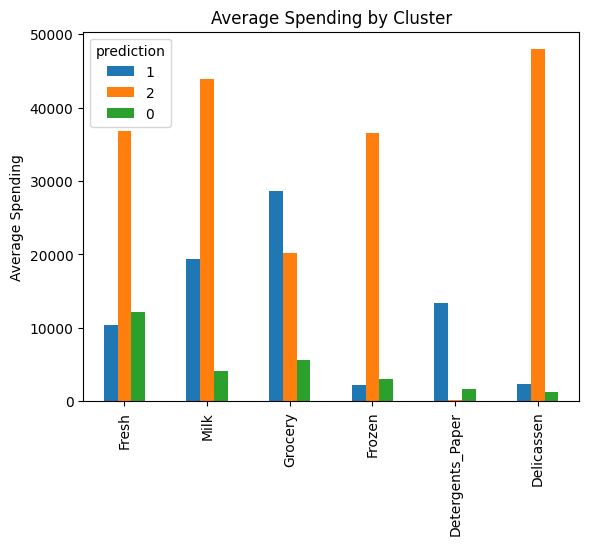

In [8]:
# Clustering with Spark MLlib - Wholesale Customers Dataset
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder.appName("CustomerClustering").getOrCreate()

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
pdf = pd.read_csv(url)
df = spark.createDataFrame(pdf)

feature_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df = assembler.transform(df)


scaler = StandardScaler(inputCol="raw_features", outputCol="features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


kmeans = KMeans(featuresCol="features", k=3, seed=42)
model = kmeans.fit(df)


predictions = model.transform(df)


print("\n=== Cluster Interpretation ===")

# 1. Show cluster sizes
print("\nCluster Sizes:")
predictions.groupBy("prediction").count().orderBy("prediction").show()

# 2. Average spending per cluster
from pyspark.sql.functions import mean

print("\nAverage Spending by Cluster:")
for col in feature_cols:
    predictions.groupBy("prediction").agg(mean(col).alias(f"avg_{col}")) \
              .orderBy("prediction").show()

# 3. Profile clusters (using pandas for visualization)
cluster_profiles = predictions.groupBy("prediction").agg(
    *[mean(c).alias(c) for c in feature_cols]
).toPandas()

import matplotlib.pyplot as plt
cluster_profiles.set_index('prediction').T.plot(kind='bar')
plt.title("Average Spending by Cluster")
plt.ylabel("Average Spending")
plt.show()

In [50]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import explode

spark = SparkSession.builder \
    .appName("SimpleMovieRecommender") \
    .getOrCreate()

ratings = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)

ratings = ratings.na.drop()

ratings = ratings.select("userId", "movieId", "rating")
ratings = ratings.withColumn("userId", ratings["userId"].cast("integer"))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast("integer"))
ratings = ratings.withColumn("rating", ratings["rating"].cast("float"))

(train, test) = ratings.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    maxIter=5,  # Number of iterations
    regParam=0.01,  # Regularization parameter
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"  # Handle new users/items by dropping them
)


model = als.fit(train)
user_recs = model.recommendForAllUsers(5)
movies = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True).na.drop()
movies = movies.select("movieId", "title")
def evaluate_model(model, test_data):
    predictions = model.transform(test_data)

    # Handle NaN predictions (cold-start items)
    predictions = predictions.na.fill(0, ["prediction"])

    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="rating",
        predictionCol="prediction"
    )

    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Show sample predictions
    print("\nSample predictions vs actual ratings:")
    predictions.join(movies, "movieId") \
        .select("userId", "title", "rating", "prediction") \
        .orderBy(rand()) \
        .limit(10) \
        .show(truncate=False)

evaluate_model(model, test)



def get_user_recommendations(user_id, num_recs=5):
    """Gets and displays the top num_recs movie recommendations for a given user."""
    user_recommendations = user_recs.filter(user_recs.userId == user_id) \
        .select(explode("recommendations")) \
        .select("col.*") \
        .join(movies, "movieId") \
        .select("title", "rating") \
        .orderBy("rating", ascending=False) \
        .limit(num_recs)

    print(f"\nTop {num_recs} recommendations for user {user_id}:")
    user_recommendations.show(truncate=False)


sample_user_id = 11  # Can be changed based on user_id's in dataset
get_user_recommendations(sample_user_id)

spark.stop()

Root Mean Squared Error (RMSE): 1.0957

Sample predictions vs actual ratings:
+------+--------------------------------------+------+----------+
|userId|title                                 |rating|prediction|
+------+--------------------------------------+------+----------+
|438   |Animal House (1978)                   |3.5   |3.9876783 |
|314   |Star Trek V: The Final Frontier (1989)|2.0   |1.525294  |
|184   |Planet Earth (2006)                   |5.0   |4.9159613 |
|409   |Rushmore (1998)                       |2.0   |4.786318  |
|93    |Dragonheart (1996)                    |4.0   |4.2566323 |
|474   |Ballad of Jack and Rose, The (2005)   |4.0   |1.5803207 |
|608   |Chronicles of Riddick, The (2004)     |4.5   |4.4361773 |
|129   |Shrek (2001)                          |3.5   |4.382971  |
|167   |Pulp Fiction (1994)                   |3.0   |4.2193246 |
|288   |Dick (1999)                           |3.5   |4.2450123 |
+------+--------------------------------------+------+----------